In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
match = pd.read_csv("Match.csv", parse_dates=["date"])
player = pd.read_csv("Player.csv")
player_attr = pd.read_csv("Player_Attributes.csv", parse_dates=["date"])
team = pd.read_csv("Team.csv")
team_attr = pd.read_csv("Team_Attributes.csv", parse_dates=["date"])

In [6]:
player_cols = [f"home_player_{i}" for i in range(1, 12)] + [f"away_player_{i}" for i in range(1, 12)]
keep_cols = ["match_api_id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal", "date"] + player_cols
match = match[keep_cols]

In [7]:
# 3. Compute match result
def get_result(row):
    if row.home_team_goal > row.away_team_goal:
        return "Win"
    elif row.home_team_goal == row.away_team_goal:
        return "Draw"
    else:
        return "Lose"

match["result"] = match.apply(get_result, axis=1)


In [8]:
# 4. Function to extract player attributes
def get_latest_player_attributes(pid, match_date):
    df = player_attr[(player_attr.player_api_id == pid) & (player_attr.date <= match_date)]
    if df.empty:
        return pd.Series([np.nan] * 4, index=["rating", "stamina", "passing", "control"])
    row = df.sort_values("date", ascending=False).iloc[0]
    return pd.Series({
        "rating": row.overall_rating,
        "stamina": row.stamina,
        "passing": row.short_passing,
        "control": row.ball_control
    })

In [9]:
# 5. Get average player attributes per team
home_stats, away_stats = [], []

for idx, row in match.iterrows():
    h_players = [row[f"home_player_{i}"] for i in range(1, 12) if pd.notna(row[f"home_player_{i}"])]
    a_players = [row[f"away_player_{i}"] for i in range(1, 12) if pd.notna(row[f"away_player_{i}"])]

    h_attrs = [get_latest_player_attributes(int(pid), row.date) for pid in h_players]
    a_attrs = [get_latest_player_attributes(int(pid), row.date) for pid in a_players]

    home_df = pd.DataFrame(h_attrs)
    away_df = pd.DataFrame(a_attrs)

    home_stats.append(home_df.mean())
    away_stats.append(away_df.mean())

home_df = pd.DataFrame(home_stats, columns=["home_rating", "home_stamina", "home_passing", "home_control"])
away_df = pd.DataFrame(away_stats, columns=["away_rating", "away_stamina", "away_passing", "away_control"])
match = pd.concat([match, home_df, away_df], axis=1)


In [10]:
# 6. Merge with latest team attributes
latest_team_attr = team_attr.sort_values("date").groupby("team_api_id").last().reset_index()
match = match.merge(latest_team_attr.add_prefix("home_"), left_on="home_team_api_id", right_on="home_team_api_id", how="left")
match = match.merge(latest_team_attr.add_prefix("away_"), left_on="away_team_api_id", right_on="away_team_api_id", how="left")


In [11]:
# 7. Select features and target
features = [
    "home_rating", "home_stamina", "home_passing", "home_control",
    "away_rating", "away_stamina", "away_passing", "away_control",
    "home_buildUpPlaySpeed", "home_chanceCreationPassing", "home_defencePressure",
    "away_buildUpPlaySpeed", "away_chanceCreationPassing", "away_defencePressure"
]

match_clean = match.dropna(subset=["result"])
X = match_clean[features]
y = match_clean["result"]

In [12]:
# 8. Impute missing values
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [13]:
# 9. Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
# 10. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [17]:
# 11. Fit model
pipeline.fit(X_train, y_train)

E:\NCI_College\User_conda\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['home_rating' 'home_stamina' 'home_passing' 'home_control' 'away_rating'
 'away_stamina' 'away_passing' 'away_control']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [18]:
# 12. Evaluate
y_pred = pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:

              precision    recall  f1-score   support

        Draw       0.25      0.19      0.22      1317
        Lose       0.39      0.37      0.38      1470
         Win       0.54      0.63      0.58      2409

    accuracy                           0.45      5196
   macro avg       0.39      0.40      0.39      5196
weighted avg       0.43      0.45      0.43      5196



E:\NCI_College\User_conda\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['home_rating' 'home_stamina' 'home_passing' 'home_control' 'away_rating'
 'away_stamina' 'away_passing' 'away_control']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [26]:
from sklearn.metrics import accuracy_score

# Assuming y_test and y_pred are already defined
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4459199384141647


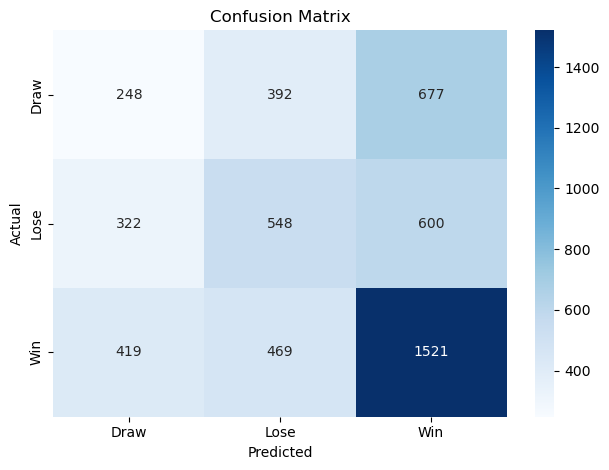

In [21]:
# 13. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

C:\Users\meghs\AppData\Local\Temp\ipykernel_13568\1658759942.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="viridis")


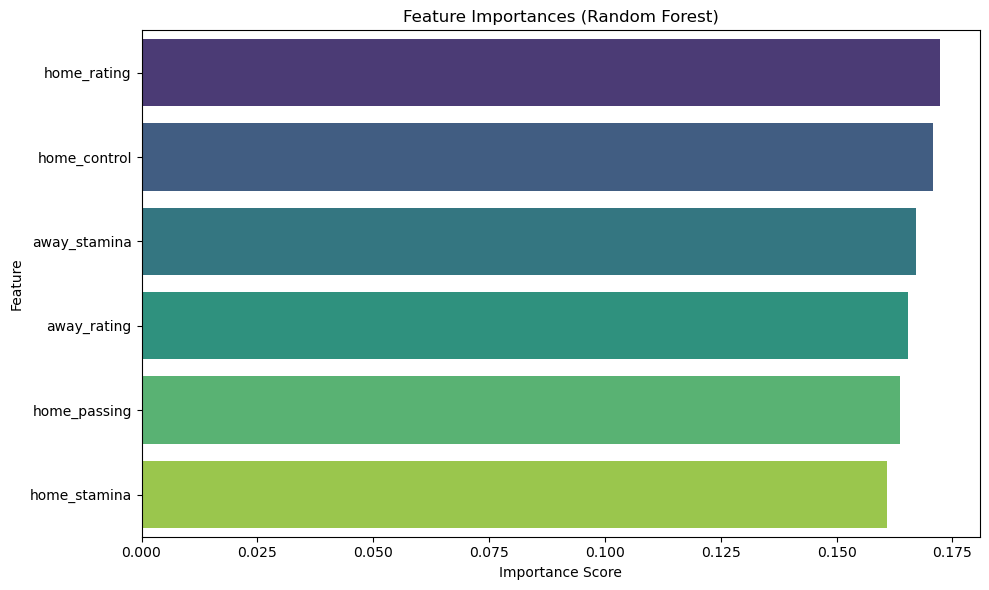

In [22]:
# 14. Feature importance plot
model = pipeline.named_steps["classifier"]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


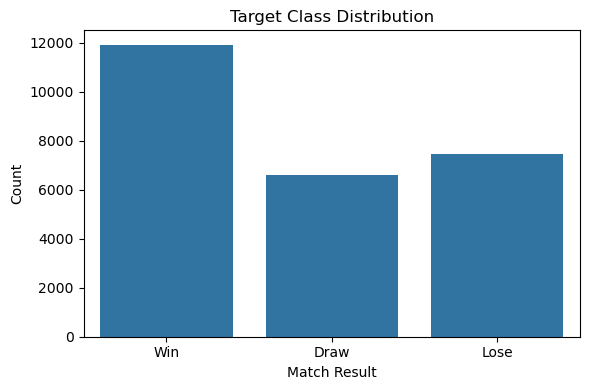

In [23]:
# 15. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y, order=["Win", "Draw", "Lose"])
plt.title("Target Class Distribution")
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

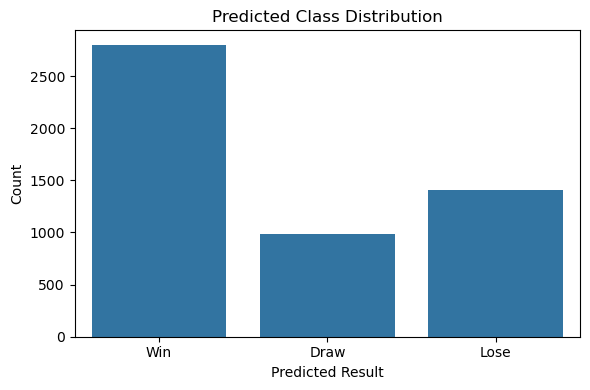

In [24]:
# 16. Prediction distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=le.inverse_transform(y_pred))
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Result")
plt.ylabel("Count")
plt.tight_layout()
plt.show()